# Hand coded Logistic Regression using Gradient Descent

Writing a logistic regression by hand is a popular programming interview question for experienced Data Scientists. In this notebook, I create a logistic regression function, and solve for the parameter estimates using gradient descent in numpy and pytorch. 

<b>Sigmoid function:</b>

$$\sigma(t) = \frac{e^{t}}{e^{t}+1} = \frac{1}{1+e^{-t}}$$

<b>Logistic Regression:</b>

The logistic regression function predicts the probability that an observation is class 1, given the x features. It can be rearranged into the format of the sigmoid function. 
$$\pi_i = P(Y=1|X=x_i) = \frac{e^{\beta_0+\beta_1x_i}}{e^{\beta_0+\beta_1x_i}+1} =  \frac{1}{1+e^{-(\beta_0+\beta_1x_i)}} = \sigma(-(\beta_0+\beta_1x_i)) = \sigma(\beta^{T}X) $$

Where $$\beta = [\beta_0, \beta_1, \beta_2, ...,\beta_k]$$
$$Y \in \{0,1\}$$
$$X = [X_1 X_2 ... X_k]$$
$$x_i = [x_{i1}, x_{i2}, ..., x_{ik}]$$
$$i = [1,2,3,...,n]$$
where n is number of observation, and k is number of features. 

## Simulated Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
#some simulated data
Y = np.sort(np.random.randint(low=0, high=2, size=2000))
X1_0 = np.random.normal(loc=0, scale=1, size=1000)
X1_1 = np.random.normal(loc=5, scale=1, size=1000)
X1 = np.hstack((X1_0, X1_1))
X2_0 = np.random.normal(loc=0, scale=1, size=1000)
X2_1 = np.random.normal(loc=2, scale=1, size=1000)
X2 = np.hstack((X2_0, X2_1))
X = np.vstack((X1, X2))

df = pd.DataFrame([Y, X1, X2]).T
df.columns = ["labels", "X1", "X2"]
df["labels"] = df.labels.astype('int')
df = df.sample(frac=1).reset_index(drop=True)

X = df[['X1', 'X2']].to_numpy()
Y = df.labels.to_numpy()

df.head(3)

,labels,X1,X2
0,0,0.479866,0.793340
1,0,-0.164330,-2.017056
2,0,0.869260,-0.293394


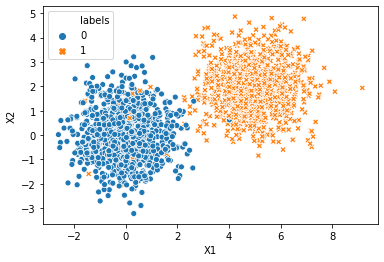

In [4]:
ax = sns.scatterplot(x="X1", y="X2",
                     hue="labels", 
                     style="labels", data=df)

# Solved in Numpy using the Maximum Likelihood Estimate:

The Maximum Likelihood Estimate method uses the likelihood function of the data to solve for the model parameters $\beta$ such that the likelihood of the data is maximized. 
<b>Loss Function</b>
The Log-Likelihood Function is
$$ l(\beta) = l(y|X; \beta) = \ln P(y|X; \beta) = \ln \prod_{i=1}^{N} \pi_i^{y_i}[1-\pi_i]^{1-y_i} = \ln \prod_{i=1}^{N} \sigma(\beta^Tx_i)^{y_i}[1-\sigma(\beta^Tx_i)]^{1-y_i} = \sum_{i=1}^{N}[y_i\ln\sigma(\beta^Tx_i)+(1-y_i)\ln(1-\sigma(\beta^Tx_i))]$$

Where $\pi_i = \sigma(\beta^Tx_i)$

<b>Gradient</b>

The Maximum Likelihood Estimate (MLE) for the parameter vector $\beta$ can be calculated from the log-likelihood function.
$$\widehat{\beta_{MLE}} = \text{argmax}_{\beta}\ l(\beta) $$

To solve for the maximum likelihood estimate using argmax, we take the derivate (gradient) of $l(\beta|X, Y)$ w.r.t. $\beta$, and set it equal to 0.

$$\nabla_\beta l = \sum_{n=1}^{n}[y_i-\sigma(\beta^Tx_i)]x_i = 0$$

This expression does not have a closed form solution, so we will use gradient descent to solve for the MLE parameter estimates $\widehat{\beta_{MLE}}$. For simplicity, I have not included the intercept in this calculation.

In [5]:
def sigmoid(scores):
    return 1 / (1 + np.exp(-scores))

def log_likelihood(B, X, Y):
    scores = np.dot(B.T, X)
    ll = np.sum(Y*np.log(sigmoid(scores))+(1-Y)*np.log(1-sigmoid(scores)))
    return ll

def gradient(X, Y, Yhat):
    gradient = np.dot(X, Y-Yhat)
    return gradient


def estimate_parameters(X, Y, epochs=100, learning_rate=0.05):
    ''' Use gradient descent to estimate beta paramters'''
    
    #randomly initialize parameter vector
    B = np.zeros(X.shape[0])

    for epoch in range(epochs+1):
        # predict values
        scores = np.dot(B.T, X)
        Yhat = sigmoid(scores)
        
        # calculate gradient
        grad = gradient(X, Y, Yhat)
        
        # update parameters
        B += learning_rate * grad
        
        #print loss functio
        if epoch % 100 == 0: 
            print(epoch, log_likelihood(B, X, Y))
        
    return B

In [8]:
#Use gradient descent to estimate logistic regression parameters
Bhat = estimate_parameters(X.T, Y, epochs=1000, learning_rate=0.001)
Bhat

0 -1250.2367468315329
100 -777.2640944260808
200 -777.2640944260806
300 -777.2640944260806
400 -777.2640944260806
500 -777.2640944260806
600 -777.2640944260806
700 -777.2640944260806
800 -777.2640944260806
900 -777.2640944260806
1000 -777.2640944260806


array([0.63978798, 0.24876519])

In [9]:
def numpy_logistic_regression(X, parameters, threshold=0.5):
    '''Use the numpy logistic regression model to predict class based on features X'''
    
    scores = np.dot(parameters.T, X) 
    Yhat = sigmoid(scores)
    
    class_pred = classify(Yhat, threshold)
    
    return Yhat, class_pred

def classify(Yhat, threshold):
    return int(Yhat >= threshold)
    

In [10]:
# example predictions
print(numpy_logistic_regression([-2, 3], Bhat))
print(numpy_logistic_regression([5, 8], Bhat))

(0.36975211302108923, 0)
(0.9944536939173191, 1)


# Solved in Pytorch using Cross Entropy Loss

Cross entropy measures the distance between the true distribution of the data $p$, and the model's learned representation of the distribution of the data $q$. The cross entropy function works out to the same expression as the MLE.

<b>Loss Function</b>
The cross entropy loss for a single observation $(y_i, x_i)$

$$H(p, q) = -\sum^1_{c=0}p(y=c) \ln q(y=c|X) =\\
-\sum^1_{c=0}I(c=y_i)\ln q(y=c|X) = \\
- \ln q(y=y_i|X)  = \\
- \ln [\pi_i^{y_i}(1-\pi_i)^{1-y_i}] =\\
- \ln [\sigma(\beta^Tx_i)^{y_i}(1-\sigma(\beta^Tx_i))^{1-y_i}] = \\
- [y_i\ln\sigma(\beta^Tx_i)+(1-y_i)\ln(1-\sigma(\beta^Tx_i))]$$

where  
$p(y=c)$ is the true distribution of the classes c  
and $\pi_i = \sigma(\beta^Tx_i)[1-\sigma(\beta^Tx_i)]^{1-y_i}$ is the learned model's distribution.

Averaged over all the observations $(y_i, x_i)$ the cross entropy loss function becomes;
$$H(p, q) = -\frac{1}{N} \sum_{i=1}^{N}[y_i\ln\sigma(\beta^Tx_i)+(1-y_i)\ln(1-\sigma(\beta^Tx_i))]$$

<b>Gradient</b>

$$\nabla_\beta l = \sum_{n=1}^{n}[y_i-\sigma(\beta^Tx_i)]x_i = 0$$


In [11]:
import torch
from fastai.basics import *

In [12]:
X_tensor = torch.Tensor(X)
Y_tensor = torch.Tensor(Y).long()

In [13]:
class LogisticRegression(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_size, num_classes)
    
    def forward(self, X):
        scores = self.linear(X)
        Yhat = F.softmax(scores, dim=1)
        return Yhat

In [14]:
input_size = 2
num_classes = 2
alpha = 0.05

lr_model = LogisticRegression(input_size, num_classes)
criterion = torch.nn.CrossEntropyLoss() 
optimizer = torch.optim.SGD(lr_model.parameters(), lr=alpha)

In [15]:
epochs = 100

for epoch in range(epochs+1):
    # predict values
    Yhat = lr_model(X_tensor)
    
    # calculate loss
    loss = criterion(Yhat, Y_tensor)
    if epoch % 10 == 0: print(epoch, loss.data)
    
    # backwards pass and update parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    

0 tensor(0.7917)
10 tensor(0.5118)
20 tensor(0.4678)
30 tensor(0.4545)
40 tensor(0.4465)
50 tensor(0.4404)
60 tensor(0.4352)
70 tensor(0.4307)
80 tensor(0.4265)
90 tensor(0.4227)
100 tensor(0.4192)


In [16]:
def pytorch_logistic_regression(X, threshold=0.5):
    '''Use the pytorch logistic regression model to predict class based on features X'''
    
    Yhat = lr_model(torch.Tensor(X).unsqueeze(0)).data[0].numpy()[1]
    
    class_pred = classify(Yhat, threshold)
    
    return Yhat, class_pred

def classify(Yhat, threshold):
    return int(Yhat >= threshold)

In [17]:
# example predictions
print(pytorch_logistic_regression([-2, 3]))
print(pytorch_logistic_regression([5, 8]))

(0.3529344, 0)
(0.99964285, 1)
